In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import utils # local file

plt.rc('text', usetex=True)
plt.rcParams['font.family'] = 'serif'
plt.rc('font', size=17)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
def calc_mean_std(x):
    return (np.mean(x), np.std(x, ddof=1) / np.sqrt(len(x)))

def color_func(p):
    if p > 0.2:
        return 'dodgerblue'
    elif p < 0.05:
        return 'orange'
    else:
        return 'seagreen'

In [7]:
df_matches = pd.read_csv('./matches_flexibility.csv', index_col=0)

In [8]:
df_matches[:3]

,MatchID,OpponentID,Outcome,OwnScore,OpponentScore,Side,CoachID,Huskies_network_params,Opponent_network_params,Huskies_mean_50time,Opponent_mean_50time,time_lag
0,1,Opponent1,win,1,0,home,Coach1,"{'clustering_coeff': 0.09591148659543136, 'sho...","{'clustering_coeff': 0.12727017100674862, 'sho...",691.105482,1487.586192,13.181913
1,2,Opponent2,tie,1,1,away,Coach1,"{'clustering_coeff': 0.13558418994397967, 'sho...","{'clustering_coeff': 0.15137551104001684, 'sho...",1283.008325,709.892932,10.458257
2,3,Opponent3,loss,0,2,away,Coach1,"{'clustering_coeff': 0.12456657946374812, 'sho...","{'clustering_coeff': 0.1305149813894459, 'shor...",786.066763,604.883916,-35.596034


# Adaptibility

## 1. Home/away??

In [10]:
df_matches.groupby('Side').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Side,,,,,,
away,19.578947,0.842105,1.894737,1156.040433,875.060139,1.133102
home,19.421053,1.473684,1.157895,1099.156815,981.738771,-7.919740


In [11]:
df_home = df_matches[df_matches['Side'] == 'home']
df_away = df_matches[df_matches['Side'] == 'away']

In [13]:
df_home[:2]

,MatchID,OpponentID,Outcome,OwnScore,OpponentScore,Side,CoachID,Huskies_network_params,Opponent_network_params,Huskies_mean_50time,Opponent_mean_50time,time_lag
0,1,Opponent1,win,1,0,home,Coach1,"{'clustering_coeff': 0.09591148659543136, 'sho...","{'clustering_coeff': 0.12727017100674862, 'sho...",691.105482,1487.586192,13.181913
3,4,Opponent4,loss,0,3,home,Coach1,"{'clustering_coeff': 0.13348612342014946, 'sho...","{'clustering_coeff': 0.10506435556251267, 'sho...",867.246184,791.518237,-32.366599


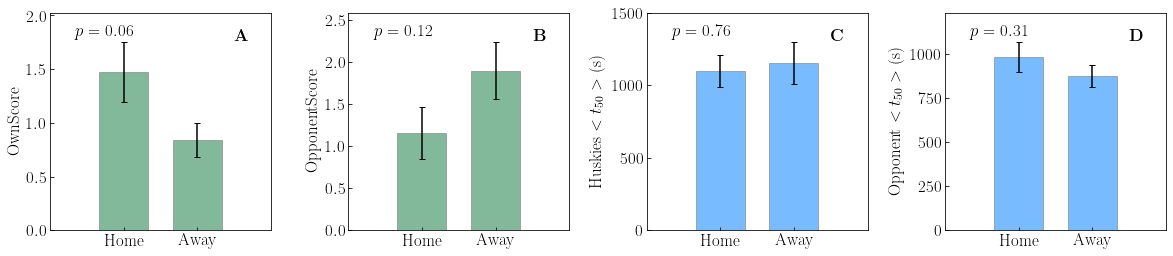

In [89]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

from scipy import stats
ylabel_set = ['OwnScore', 'OpponentScore', 
              r'Huskies $<t_{50}>$ (s)', r'Opponent $<t_{50}>$ (s)']

tag_set = ['A', 'B', 'C', 'D', 'E', 'F']

for ind, column in enumerate(['OwnScore', 'OpponentScore', 
                              'Huskies_mean_50time', 'Opponent_mean_50time']):
    ax = axes[ind % 4]
    
    home = calc_mean_std(df_home[column]) 
    away = calc_mean_std(df_away[column])
    
    levene = stats.levene(df_home[column], df_away[column])
    ttest = stats.ttest_ind(df_home[column], df_away[column], 
                            equal_var=(levene.pvalue > 0.10))
    pvalue = ttest.pvalue

    x_label = ['Home', 'Away']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [home[0], away[0]], 
           yerr=[home[1], away[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.2f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
    ax.text(3.9, ylim[1] - (ylim[1] - ylim[0]) * 0.02, 
            r'$\textbf{' + tag_set[ind] + '}$', 
            fontsize=17,
            fontweight='bold',
            horizontalalignment='center', 
            verticalalignment='center')
    
plt.subplots_adjust(wspace=0.35)

plt.savefig('./Draft/home-away-score.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/home-away-score.png', dpi=200, bbox_inches='tight')

network params是否有区别？？？ 没求区别。。。

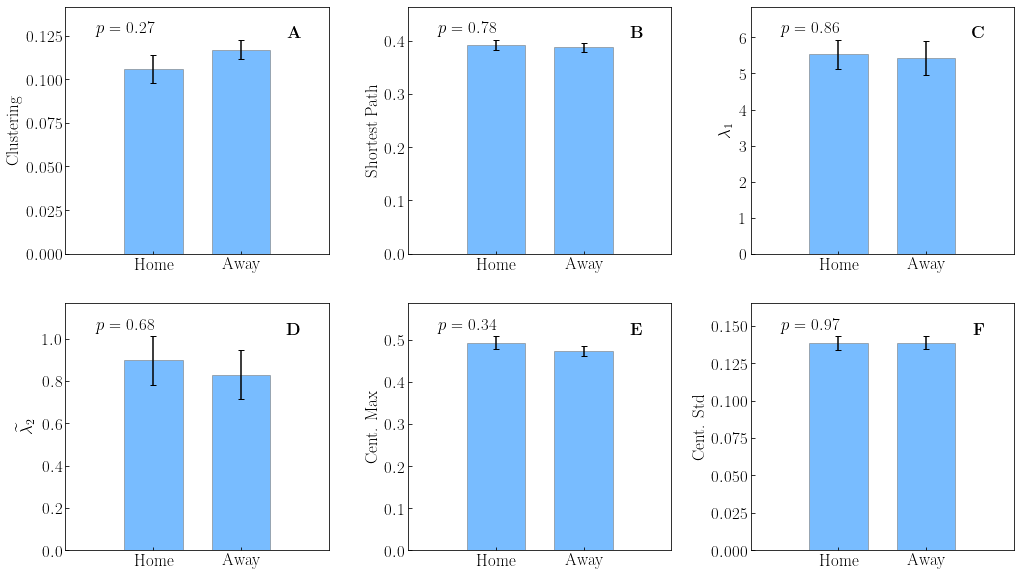

In [85]:
fig, axes = plt.subplots(2, 3, figsize=(17, 10))

from scipy import stats
ylabel_set = ['Clustering', 'Shortest Path', 
              r'$\lambda_1$', r'$\widetilde{\lambda_2}$', 
              'Cent. Max', 'Cent. Std']

for ind, column in enumerate(['clustering_coeff', 'shortest_path', 
                              'largest_eigenvalue', 'algebraic_conn', 
                              'eigen_cen_max', 'eigen_cen_std']):
    ax = axes[ind // 3, ind % 3]
    
    home_params = pd.DataFrame({ind: eval(item) for ind, item in df_home['Huskies_network_params'].iteritems()}).T
    away_params = pd.DataFrame({ind: eval(item) for ind, item in df_away['Huskies_network_params'].iteritems()}).T
    
    home = calc_mean_std(home_params[column]) 
    away = calc_mean_std(away_params[column])
    
    levene = stats.levene(home_params[column], away_params[column])
    ttest = stats.ttest_ind(home_params[column], away_params[column], 
                            equal_var=(levene.pvalue > 0.10))
    pvalue = ttest.pvalue

    x_label = ['Home', 'Away']
    x_pos = [1.5, 3.0]
    
    ax.bar(x_pos, [home[0], away[0]], 
           yerr=[home[1], away[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ylim = ax.get_ylim()
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.2f}$'.format(pvalue))
    ax.set_xlim(0, 4.5)
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    ax.tick_params(direction='in')
    
    ax.text(3.9, ylim[1] - (ylim[1] - ylim[0]) * 0.02, 
            r'$\textbf{' + tag_set[ind] + '}$', 
            fontsize=17,
            fontweight='bold',
            horizontalalignment='center', 
            verticalalignment='center')
    
plt.subplots_adjust(wspace=0.3) 

## 2. Coach?

In [32]:
df_matches.groupby('CoachID').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
CoachID,,,,,,
Coach1,5.0,0.777778,2.00,933.327948,913.615427,-8.802039
Coach2,12.0,2.000000,2.00,1316.198610,856.199312,-1.421211
Coach3,26.5,1.125000,1.25,1161.158463,948.985162,-1.775905


ANOVA

In [43]:
stats.f_oneway(df_matches[df_matches['CoachID'] == 'Coach1']['OwnScore'], 
               df_matches[df_matches['CoachID'] == 'Coach2']['OwnScore'], 
               df_matches[df_matches['CoachID'] == 'Coach3']['OwnScore'])

F_onewayResult(statistic=2.4944395731303057, pvalue=0.09710782489844355)

不同coach会导致score不同吗？

In [38]:
df_matches[df_matches['CoachID'] == 'Coach1'].groupby('Outcome').mean()

,MatchID,OwnScore,OpponentScore,Huskies_mean_50time,Opponent_mean_50time,time_lag
Outcome,,,,,,
loss,5.6,0.4,3.0,939.330040,824.991737,-21.938465
tie,5.0,1.0,1.0,1084.037999,842.096903,9.423518
win,3.5,1.5,0.5,767.612669,1206.693176,5.813469


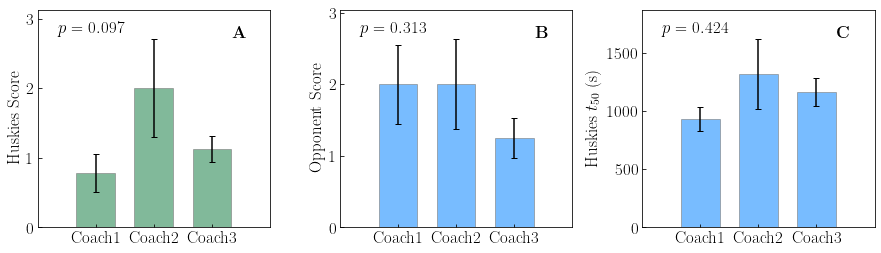

In [92]:
# Coach difference??
from scipy import stats
from utils import color_func, calc_mean_std

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=False)

ylabel_set = [r'Huskies Score', r'Opponent Score', 'Huskies $t_{50}$ (s)']

tag_set = ['A', 'B', 'C', 'D', 'E', 'F']

for ind, column in enumerate(['OwnScore', 'OpponentScore', 'Huskies_mean_50time']):
    ax = axes[ind]
    
    score_dict = {outcome: 
                  df_matches[df_matches['CoachID'] == outcome][column] for outcome in ['Coach1', 'Coach2', 'Coach3']}
    
    win = calc_mean_std(score_dict['Coach1'])
    tie = calc_mean_std(score_dict['Coach2'])
    loss = calc_mean_std(score_dict['Coach3'])
    
    anova = stats.f_oneway(score_dict['Coach1'].values, 
                           score_dict['Coach2'].values, 
                           score_dict['Coach3'].values)
    pvalue = anova.pvalue

    x_label = ['Coach1', 'Coach2', 'Coach3']
    
    x_pos = [1.5, 3.0, 4.5]
    
    ax.bar(x_pos, [win[0], tie[0], loss[0]], 
           yerr=[win[1], tie[1], loss[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ax.tick_params(direction='in', labelleft=True)
    ylim = ax.get_ylim()
    ax.set_xlim(0, 6)
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.3f}$'.format(pvalue))
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    #ax.text(0.5, 1800, r'$p={:.3f}$'.format(pvalue))
    #ax.set_ylim(0, 2000)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    
    ax.text(5.2, ylim[1] - (ylim[1] - ylim[0]) * 0.02, 
            r'$\textbf{' + tag_set[ind] + '}$', 
            fontsize=17,
            fontweight='bold',
            horizontalalignment='center', 
            verticalalignment='center')
    
    
plt.subplots_adjust(wspace=0.3)

plt.savefig('./Draft/coach-score.pdf', dpi=200, bbox_inches='tight')
plt.savefig('./Draft/coach-score.png', dpi=200, bbox_inches='tight')

不同coach会导致structure/network不同吗？ 没求不同！

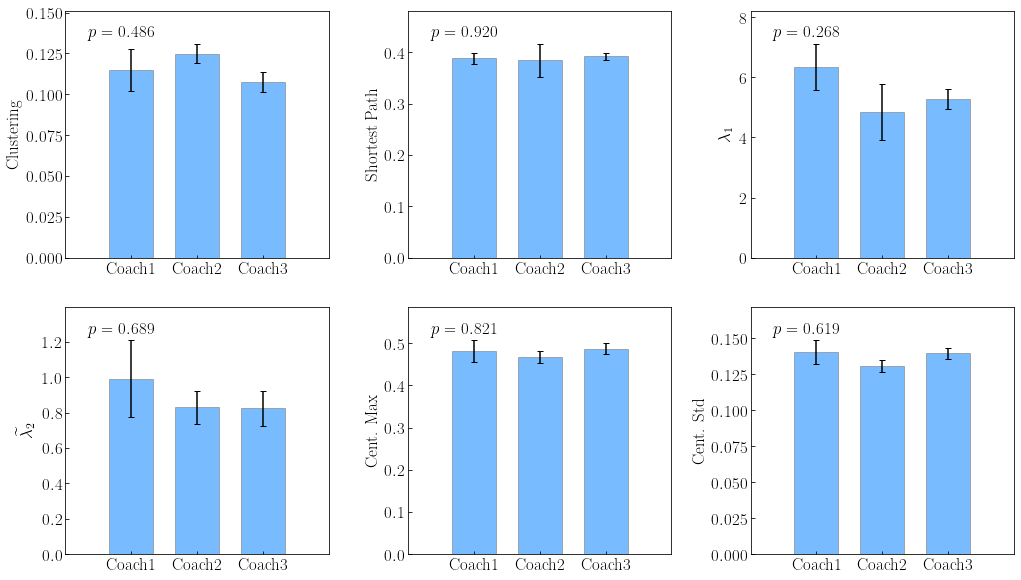

In [74]:
# Coach difference??
from scipy import stats
from utils import color_func, calc_mean_std

fig, axes = plt.subplots(2, 3, figsize=(17, 10))

ylabel_set = ['Clustering', 'Shortest Path', 
              r'$\lambda_1$', r'$\widetilde{\lambda_2}$', 
              'Cent. Max', 'Cent. Std']


for ind, column in enumerate(['clustering_coeff', 'shortest_path', 
                              'largest_eigenvalue', 'algebraic_conn', 
                              'eigen_cen_max', 'eigen_cen_std']):
    ax = axes[ind // 3, ind % 3]
    
    
    score_dict = {
                    outcome: df_matches[df_matches['CoachID'] == outcome]
                    for outcome in ['Coach1', 'Coach2', 'Coach3']
                 }
    
    win_params = pd.DataFrame({ind: eval(item) for ind, item in score_dict['Coach1']['Huskies_network_params'].iteritems()}).T
    tie_params = pd.DataFrame({ind: eval(item) for ind, item in score_dict['Coach2']['Huskies_network_params'].iteritems()}).T
    loss_params = pd.DataFrame({ind: eval(item) for ind, item in score_dict['Coach3']['Huskies_network_params'].iteritems()}).T
    
    
    win = calc_mean_std(win_params[column])
    tie = calc_mean_std(tie_params[column])
    loss = calc_mean_std(loss_params[column])
    
    anova = stats.f_oneway(win_params[column].values, 
                           tie_params[column].values, 
                           loss_params[column].values)
    pvalue = anova.pvalue

    x_label = ['Coach1', 'Coach2', 'Coach3']
    
    x_pos = [1.5, 3.0, 4.5]
    
    ax.bar(x_pos, [win[0], tie[0], loss[0]], 
           yerr=[win[1], tie[1], loss[1]], 
           error_kw={'capsize': 3}, 
           width=1, color=color_func(pvalue), 
           edgecolor='gray',
           alpha=0.6)
    ax.tick_params(direction='in', labelleft=True)
    ylim = ax.get_ylim()
    ax.set_xlim(0, 6)
    ax.text(0.5, ylim[1] - (ylim[1] - ylim[0]) * 0.02, r'$p={:.3f}$'.format(pvalue))
    ax.set_ylim(ylim[0], ylim[0] + 1.1 * (ylim[1] - ylim[0]))
    #ax.text(0.5, 1800, r'$p={:.3f}$'.format(pvalue))
    #ax.set_ylim(0, 2000)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_label)
    ax.set_ylabel(ylabel_set[ind])
    
    
plt.subplots_adjust(wspace=0.3)

#plt.savefig('./Draft/top6-network-params.pdf', dpi=200, bbox_inches='tight')
#plt.savefig('./Draft/top6-network-params.png', dpi=200, bbox_inches='tight')

不同coach应该在classical metric上有区别吧！